# Data Challenge MDI341 - Camille COCHENER

## Functional anomaly detection

**Anomaly detection** (or **outlier detection**) comprises the **machine learning** methods aimed at identification of observations that exhibit suspicious behaviour and are very likely to cause a problem. In the **unsupervised learning** framework, no label indicating whether a training observation is anomalous or not is available. Hence, anomalies should be identified in an automatic way by learning the *normal* behavior, that of the vast majority of the observations, and considering those differing significantly from it as *abnormal*. Logically, anomalies are rare in the data and thus fall in *low density* regions: anomaly detection thus boils down to identifying the *tail* of the distribution.

With the ubiquitous deployment of sensors monitoring nearly continuously the health of complex infrastructures, **anomaly detection** can now rely on measurements sampled at a very high frequency, providing a very rich representation of the phenomenon under surveillance. In order to exploit fully the collected information, the observations cannot be treated as multivariate data anymore and a functional analysis approach is required.

A (very) short list of **literature** regarding functional anomaly detection can include:
 - J.O. Ramsay, Silverman, B.W. (2005): Functional Data Analysis. Springer-Verlag, New-York.
 - Ferraty, F., Vieu, P. (2006): Nonparametric Functional Data Analysis: Theory and Practice. Springer Science & Business Media.
 - Chandola, V., Banerjee, A., Kumar, V. (2009): Anomaly detection: A survey. ACM Computing Surveys (CSUR) 41(3), 1-58.
 - Hubert, M., Rousseeuw, P.J., Segaert, P. (2015): Multivariate functional outlier detection. Statistical Methods & Applications 24(2), 177-202.
 - Wang, J.L., Chiou, J.M., Müller, H.G. (2016): Functional data analysis. Annual Review of Statistics and Its Application 3, 257-295.

## Context of the challenge 

Flight engineers attach a large number of sensors to the test helicopters to capture every nuance of their behaviour. To improve the detection of early warning signals in this vast amount of data, Airbus is encouraging research into a new way to pinpoint potential problems, including outliers. A multi-disciplinary team of specialist engineers accompanies each flight to study this mass of observations - a major investment for every flight made.

The aim of the challenge is thus **to develop a method for using unmonitored AI to detect anomalies in the accelerometer data of helicopters pre-certified by Airbus**.

The **dataset provided by Airbus** consists in measurements of accelerometers of helicopters during 1 minute at frequency 1024 Hertz, which yields time series measured at in total 60 * 1024 = 61440 equidistant time points.

Let's get started by loading the libraries we are going to use. As the work was done on Google Colab, some libraries had to be reinstalled and the architecture of the drive account as to be mounted. Furthermore, R and Python have been used in this notebook, the R magic has been activated.

In [0]:
# Library installation
#!pip install pyod
#!pip install --upgrade statsmodels
#!pip install nolds
#!pip install tsfresh
#!pip install tslearn

In [0]:
# Library loading
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import resample
from scipy import stats
from tqdm import tqdm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import skew

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from tslearn.clustering import TimeSeriesKMeans

from pyod.models.feature_bagging import FeatureBagging
from pyod.models.lof import LOF
from pyod.utils.utility import standardizer

from tsfresh.feature_extraction.feature_calculators import abs_energy, kurtosis, mean_abs_change, autocorrelation, skewness, ar_coefficient, linear_trend, \
number_crossing_m, longest_strike_above_mean, longest_strike_below_mean, fft_aggregated, absolute_sum_of_changes, partial_autocorrelation

%matplotlib inline

In [3]:
# Activate R magic
%load_ext rpy2.ipython

/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex
/usr/local/lib/python3.6/dist-packages/rpy2/robjects/pandas2ri.py:34: UserWarning: pandas >= 1.0 is not supported.
  warnings.warn('pandas >= 1.0 is not supported.')


In [0]:
# R packages installation and importation
%%R
#install.packages("devtools")
#install.packages("remotes")
#remotes::install_github("robjhyndman/forecast")
#devtools::install_github("robjhyndman/tsfeatures")
#install.packages("reticulate")

library(tsfeatures)
library(dplyr)
library(reticulate)

In [6]:
# Drive connection
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


<a id='TOC'></a>

## <font color="darkblue">Table of contents</font>
1. [Introduction](#first-bullet)  
    1.1 [Datasets of measures from accelerometers](#first-bullet)  
    1.2 [Overview of the anomaly detection algorithm](#second-bullet)  
2. [Data exploration](#third-bullet)  
3. [Data preprocessing](#fourth-bullet)  
    3.1 [Feature extraction with R](#fourth-bullet)  
    3.2 [Preprocess pipeline](#fourth-two-bullet)  
4. [Implement the anomaly detection algorithms](#fifth-bullet)  

## 1 - Introduction <a class="anchor" id="first-bullet"></a>

### 1.1 - Datasets of measures from accelerometers

Let's start by importing and exploring the datasets.

The dataset is divided into two parts:

* the **training set** contains 1677 observations and 61440 entries, measures with equivalent time distance of 1 / 1024 seconds.
* the **test set** contains 2511 observations and has the same structure as the training set.

There is no labels as we are working in an unsupervised context. 

Let's load the datasets using the code below.

In [0]:
X_train = pd.read_csv('/content/drive/My Drive/MDI341 - Data Challenge/data/airbus_train.csv', header=None, sep=' ')
X_test = pd.read_csv('/content/drive/My Drive/MDI341 - Data Challenge/data/airbus_test.csv', header=None, sep=' ')

Back to [table of contents](#TOC)

### 1.2 - Overview of the anomaly detection algorithm <a class="anchor" id="second-bullet"></a>

#### Inputs and outputs
* The input of the model is a serie of measurements of accelerometers through time
* The output will be an anomaly score for the observation in the corresponding row

#### Preprocessing

In time series multivariate anomaly detection, there are two options. The first one is to use a time series specific method. An example would be LSTM, or a recurrent neural network in general. The other one is to extract features from the series and use them with normal unsupervised learning. In this study, feature extraction with outlier detection algorithms have been chosen. 

The method is divided into two parts.

* First, a downsample technique reducing the frequency of the time series computing the mean on 1024 windows has been performed. Then, a PCA allows to extract 10 relevant information-carrying components. 

* Secondly, a set of features has been computed from the raw data. Some features have been extracted with the R package ```tsfeatures```. Here is a summary of the extracted features :

|Features | Description | 
|------|------|
| min |   The minimum of the time series  |
| max |   The maximum of the time series  |
| mean |   The mean of the time series  |
| std |   The standard deviation of the time series  |
| var |   The variance of the time series  |
| skewness |  It indicates the symmetry of the probability density function of the amplitude of a time series  |
| acf_1 |   Correlation of the series with itself at lag 1  |
| acf_2 |   Correlation of the series with itself at lag 2  |
| acf_3 |   Correlation of the series with itself at lag 3  |
| acf_4 |   Correlation of the series with itself at lag 4  |
| acf_5 |   Correlation of the series with itself at lag 5  |
| trend |   Measure of trend of a time series based on an STL decomposition  |
| spike |   Measures the “spikiness” of a time series, and is computed as the variance of the leave-one-out variances of the remainder component $e_t$  |

#### Anomaly detection algorithm

I used the Local Outlier Factor (LOF) algorithm with Feature Bagging and 5 neighbors : 

* The LOF algorithm proposed by Markus M. Breunig, Hans-Peter Kriegel, Raymond T. Ng and Jörg Sander in 2000 allows to find abnormal data points by measuring the local deviation of a given data point from its neighbours. 
* Feature bagging is an ensemble technique where every outlier detection algorithm uses a small subset of features that are randomly selected from the original feature set. As a result, each outlier detector identifies different outliers. The outlier scores computed by the individual outlier detection algorithms are then combined in order to find the better quality outliers.

#### Subsmission summary

As the task is unsupervised, the only feedback is the score calculated by the submission website.

| AUC |
| ----- |
| 0.86912133 |

Back to [table of contents](#TOC)

## 2 - Data exploration <a class="anchor" id="third-bullet"></a>

Before and during the analyses, it was important to study the time series visually to try to understand their behaviour. This helped to determine the size of the windows or the relevant parameters to be considered in the model.

Text(0.5, 1.0, 'Subset of measurements of accelerometers over time')

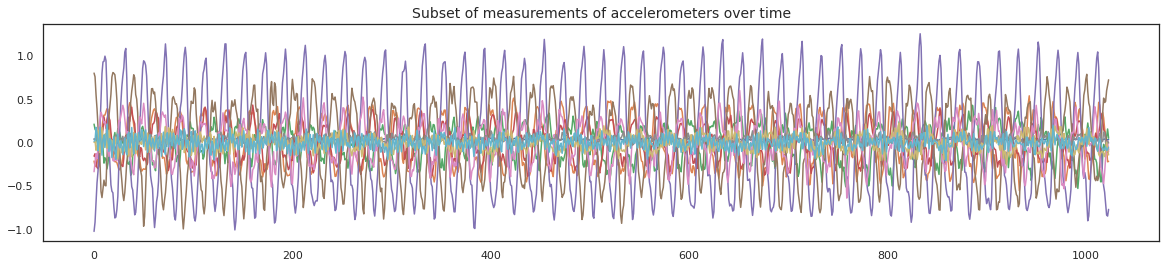

In [174]:
plt.figure(figsize=(20,4))
for i in range(0,10):
      plt.plot(X_train.iloc[i][:1024])
plt.title("Subset of measurements of accelerometers over time", fontsize=14)

Text(0.5, 1.0, 'Distribution of measurements of accelerometers')

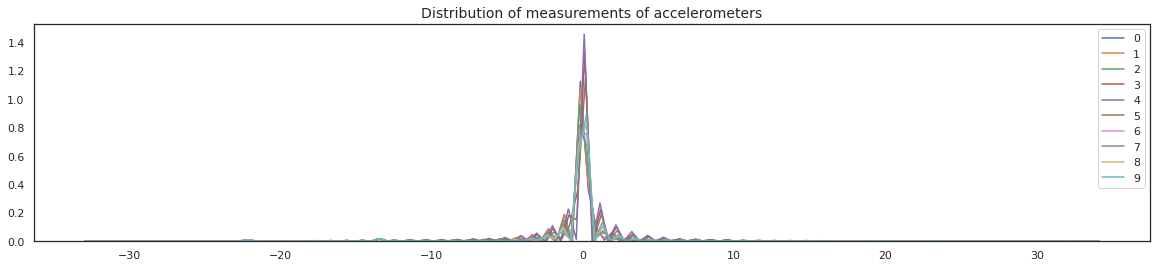

In [175]:
plt.figure(figsize=(20,4))
for i in range(0,10):
     sns.kdeplot(X_test[i])
plt.title("Distribution of measurements of accelerometers", fontsize=14)

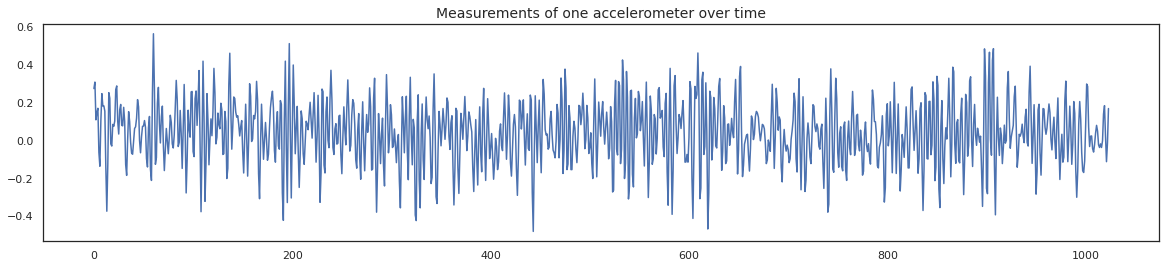

In [176]:
plt.figure(figsize=(20,4))
plt.plot(X_test.iloc[2000][:1024])
plt.title("Measurements of one accelerometer over time", fontsize=14);

Some sensors generated constant measurements over time in the test set. These sensors have been identified. 

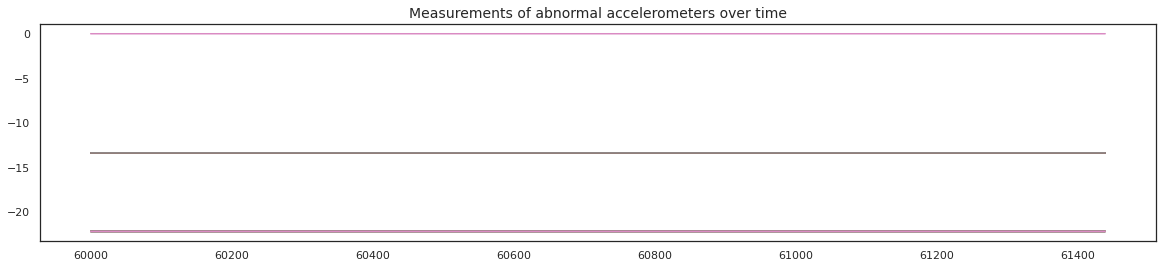

In [178]:
plt.figure(figsize=(20, 4))
cste_series = np.where(X_test_features['var']<0.000001)[0]
for i in cste_series:
      plt.plot(X_test.iloc[i][60000:])
plt.title("Measurements of abnormal accelerometers over time", fontsize=14);

As these were time series, I also analyzed the autocorrelations. It gives a good indication of the nature of the time series in general. 

**Autocorrelation** measures the linear relationship between lagged values of a time series, for example between $y_t$ and $y_{t-1}$. If a series is significantly autocorrelated, that means, the previous values of the series (lags) may be helpful in predicting the current value.

**Partial autocorrelations** measure the linear dependence of one variable after removing the effect of other variable(s) that affect both variables. That is, the partial autocorrelation at lag $k$ is the autocorrelation between $y_t$ and $y_t$+$y_{t+k}$ that is not accounted for by lags 1 through $k−1$. 

Here is the plot of the autocorrelation and partial autocorrelation of one time series :

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


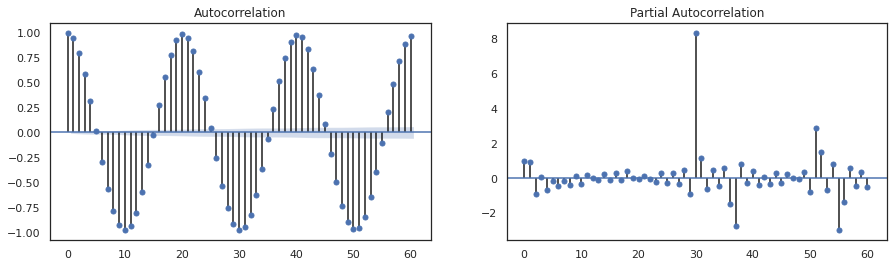

In [60]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(15, 4))
plot_acf(X_train.iloc[2], lags=60, ax=ax[0]); 
plot_pacf(X_train.iloc[2], lags=60, ax=ax[1]); 

The zero-lag has a correlation of 1 because it correlates with itself perfectly. The plot indicates a very high autocorrelation for the $10_{th}$ and $20_{th}$ time. The serie is clearly cyclic, with a period of 0.02 secondes. There is a significant and very high partial correlation at lag 30 (positive).

Back to [table of contents](#TOC)

## 3 - Data preprocessing <a class="anchor" id="fourth-bullet"></a>

### 3.1 - Feature extraction with R <a class="anchor" id="fourth-bullet"></a>

As explained above, a large set of features have been extracted using an R package, ```tsfeatures``` created by Yangzhuoran Yang and Rob J Hyndman. 

Here is the code used :

In [0]:
%%R
Xtrain <- read.csv("/content/drive/My Drive/MDI341 - Data Challenge/data/airbus_train.csv", header=FALSE, sep=' ')
Xtest <- read.csv("/content/drive/My Drive/MDI341 - Data Challenge/data/airbus_test.csv", header=FALSE, sep=' ')

In [152]:
%%R
print(dim(Xtrain))
print(dim(Xtest))

[1]  1677 61440
[1]  2511 61440


In [0]:
%%R
extract_features <- function(x, nrows) {
    mat <- matrix(ncol=15, nrow=nrows)

    for (i in 1:nrows){
      print(i)
      hwl <- bind_cols(
            tsfeatures(as.numeric(x[i,]),
              c("acf_features","entropy","lumpiness","flat_spots","crossing_points")),
            tsfeatures(as.numeric(x[i,]),"stl_features", s.window='periodic', robust=TRUE),
            tsfeatures(as.numeric(x[i,]), "max_kl_shift", width=64),
            tsfeatures(as.numeric(x[i,]),
              c("mean","var"), scale=FALSE, na.rm=TRUE),
            tsfeatures(as.numeric(x[i,]),
              c("max_level_shift","max_var_shift"), trim=TRUE)) %>%
      select(mean, var, x_acf1, trend, linearity, curvature,
            entropy, lumpiness, spike, max_level_shift, max_var_shift, flat_spots,
            crossing_points, max_kl_shift, time_kl_shift)
  
      mat[i,] <- as.numeric(hwl)
    }

    mat <- data.frame(mat)
    return(mat)
}


In [61]:
%%R
#Xtrain <- extract_features(Xtrain, nrows=1677)
#colnames(Xtrain) <- c("mean", "var", "x_acf1", "trend", "linearity", "curvature",
#         "entropy", "lumpiness", "spike", "max_level_shift", "max_var_shift", "flat_spots",
#         "crossing_points", "max_kl_shift", "time_kl_shift")
#write.csv(Xtrain,"/content/drive/My Drive/MDI341 - Data Challenge/data/features_train.csv", row.names = FALSE)

NULL


In [0]:
%%R
#Xtest <- extract_features(Xtest, nrows=2511)
#colnames(Xtest) <- c("mean", "var", "x_acf1", "trend", "linearity", "curvature",
#         "entropy", "lumpiness", "spike", "max_level_shift", "max_var_shift", "flat_spots",
#         "crossing_points", "max_kl_shift", "time_kl_shift")
#write.csv(Xtest,"/content/drive/My Drive/MDI341 - Data Challenge/data/features_test.csv", row.names = FALSE)

The code takes a while to run. For simplicity, the final matrix has been saved and reloaded if necessary.

In [0]:
X_train_features = pd.read_csv('/content/drive/My Drive/MDI341 - Data Challenge/data/features_train.csv', header=0, sep=',')
X_test_features = pd.read_csv('/content/drive/My Drive/MDI341 - Data Challenge/data/features_test.csv', header=0, sep=',')

In [63]:
print("Features available : \n", X_train_features.columns)

Features available : 
 Index(['mean', 'var', 'x_acf1', 'trend', 'linearity', 'curvature', 'entropy',
       'lumpiness', 'spike', 'max_level_shift', 'max_var_shift', 'flat_spots',
       'crossing_points', 'max_kl_shift', 'time_kl_shift'],
      dtype='object')


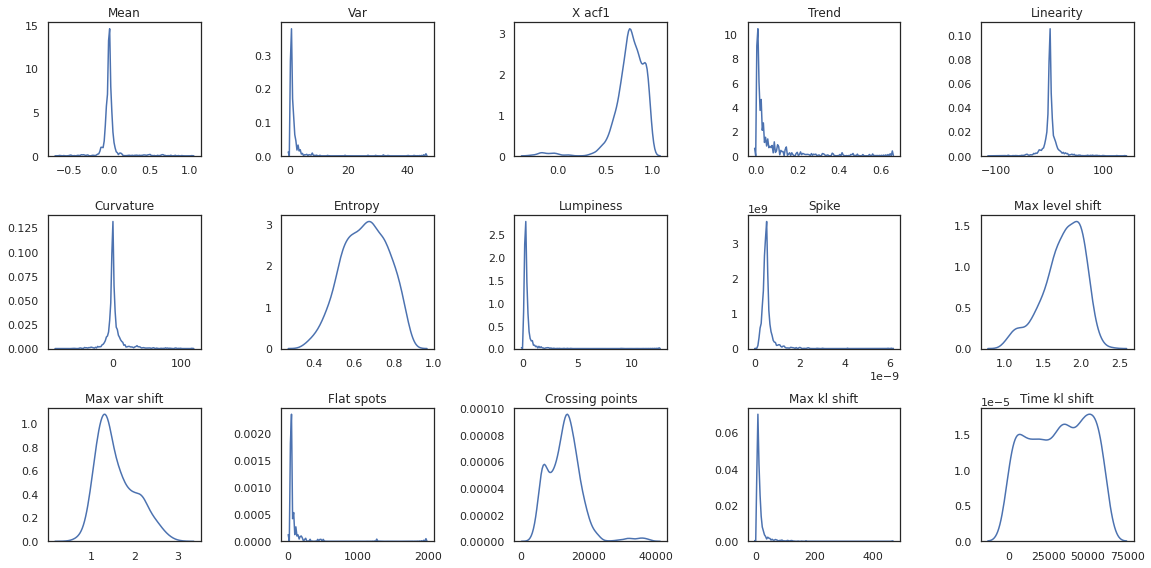

In [64]:
fig = plt.figure(figsize=(16,8))

for i in range(0, 15):
    ax = fig.add_subplot(3, 5, i+1)
    ax = sns.kdeplot(X_train_features.iloc[:,i])
    ax.legend_.remove()
    ax.set_title(X_train_features.columns[i].capitalize().replace("_", " "))

fig.tight_layout();

Back to [table of contents](#TOC)

### 3.2 - Preprocess pipeline <a class="anchor" id="fourth-two-bullet"></a>

This section contains the data preprocessing pipeline, i.e. :

* A downsample step of the data where the mean of the time series has been computed on 32-size windows. 
* A PCA components extraction from the downsampled series (10 components).
* Computations of a set of additional features as min, max, standard deviation, skewness, and autocorrelation at different lags.

Both train and test sets have been processed in this part. At the end, they contain exaclty the same features. 

In [0]:
def resample_col(x):
    idx = pd.date_range('2018-01-01', periods=61440, freq='D')
    x.index = idx
    newx = x.resample('32D').mean() 
    return newx

In [0]:
def preprocess(data):

    tqdm.pandas()

    # Step 1 - compute mean on 32 points windows
    data_downsampled = data.apply(lambda x: resample_col(x), axis=1)
  
    # Step 2 - perform a pca to reduce the data and keep the 10 first components
    pca = PCA(n_components = 10, whiten = True)
    pca.fit(data_downsampled)
    data_reduced_pca = pd.DataFrame(pca.fit_transform(data_downsampled))

    # Step 3 - feature engineering from raw data
    data_reduced_pca['min'] = data.min(axis=1)
    data_reduced_pca['max'] = data.max(axis=1)
    data_reduced_pca['std'] = data.std(axis=1)
    data_reduced_pca['skewness'] = data.progress_apply(lambda x: x.skew(), axis=1)
    data_reduced_pca['acf_2'] = data.progress_apply(lambda x: x.autocorr(lag=2), axis=1)
    data_reduced_pca['acf_3'] = data.progress_apply(lambda x: x.autocorr(lag=3), axis=1)
    data_reduced_pca['acf_4'] = data.progress_apply(lambda x: x.autocorr(lag=4), axis=1)
    data_reduced_pca['acf_5'] = data.progress_apply(lambda x: x.autocorr(lag=5), axis=1)

    return data_reduced_pca

In [180]:
%%time
X_train_transform = pd.concat([preprocess(X_train), X_train_features, X_train_features_one], axis=1)
X_test_transform = pd.concat([preprocess(X_test), X_test_features, X_test_features_one], axis=1)

100%|██████████| 2511/2511 [00:04<00:00, 505.65it/s]

CPU times: user 1min 10s, sys: 1.71 s, total: 1min 12s
Wall time: 1min 10s


The complete concatenated dataset is the following :

In [181]:
X_train_transform.head()

,0,1,2,3,4,5,6,7,8,9,min,max,std,skewness,acf_2,acf_3,acf_4,acf_5,mean,var,x_acf1,trend,linearity,curvature,entropy,lumpiness,spike,max_level_shift,max_var_shift,flat_spots,crossing_points,max_kl_shift,time_kl_shift,mat
0,0.238367,-0.010964,0.027633,0.016799,-0.049353,-0.012701,-0.012514,0.008784,0.017788,-0.023943,-0.247552,0.299668,0.024919,-0.040011,-0.515678,-0.271210,0.418541,0.299643,0.039373,0.000621,0.349354,2.707860e-04,-1.941996,-2.010586,0.877101,9.006481,4.126567e-09,1.220016,0.798341,428,18631,47.481795,56554,0.834717
1,-0.048213,-0.300014,-0.274136,0.247185,-0.035688,0.119173,-0.127822,-0.210263,0.293978,0.126483,-1.295304,1.423423,0.695547,0.054606,0.788707,0.571797,0.309440,0.015906,0.003725,0.483785,0.942218,3.049167e-06,-0.185948,-0.116449,0.369988,0.131190,1.570666e-10,1.885073,0.893839,10,6090,0.157443,55876,0.097616
2,0.020979,0.296119,0.438609,-0.259687,-0.045174,-0.161043,0.150153,0.340376,-0.373456,-0.185671,-1.745115,1.748343,0.852313,0.002215,0.799272,0.582406,0.312979,0.011697,0.012775,0.726437,0.946267,3.127492e-06,0.121313,-0.106790,0.357799,0.151663,1.817039e-10,1.796161,0.662656,18,6188,0.176434,47990,0.036267
3,-0.040279,-0.030979,0.012714,0.011203,-0.027868,-0.017608,0.033692,0.022187,0.023292,-0.081907,-0.748198,0.717880,0.145046,-0.010889,0.075474,-0.203183,-0.157074,0.019007,0.004919,0.021038,0.657896,6.535412e-07,0.034627,-0.159938,0.759377,0.622189,6.819252e-10,2.403736,2.610337,17,17455,7.284131,5498,0.003995
4,0.180952,-0.082593,-0.030470,0.048502,-0.042311,-0.106057,0.090093,0.034855,0.088143,-0.152163,-1.213873,1.402794,0.656018,0.118328,0.776372,0.552749,0.290699,0.005509,0.032258,0.430360,0.938372,1.795976e-04,0.336548,0.069594,0.365835,0.127488,1.545381e-10,1.998233,0.841562,12,6172,0.414000,56843,0.659913


In [0]:
X_train_transform = X_train_transform.drop(['linearity','curvature','entropy', 'lumpiness', 'max_level_shift', 'max_var_shift','flat_spots','crossing_points', 'max_kl_shift','time_kl_shift'], axis=1)
X_test_transform = X_test_transform.drop(['linearity','curvature','entropy', 'lumpiness', 'max_level_shift', 'max_var_shift','flat_spots','crossing_points', 'max_kl_shift','time_kl_shift'], axis=1)

The test set contains missing values due to computation. These values were replaced by zero.

In [0]:
X_test_transform = X_test_transform.fillna(0)

Briefly, check the correlations between all the features.

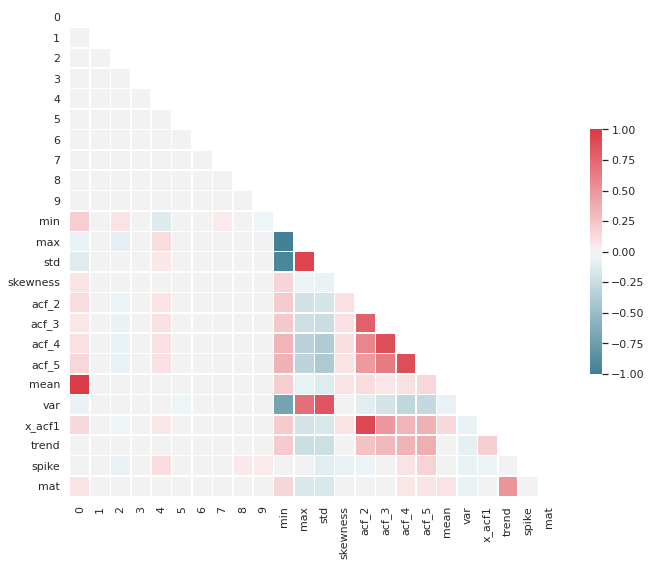

In [184]:
sns.set(style="white")
corr = X_train_transform.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, 
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmin=-1, vmax=1, center= 0)

In [185]:
X_train_transform.head()

,0,1,2,3,4,5,6,7,8,9,min,max,std,skewness,acf_2,acf_3,acf_4,acf_5,mean,var,x_acf1,trend,spike,mat
0,0.238367,-0.010964,0.027633,0.016799,-0.049353,-0.012701,-0.012514,0.008784,0.017788,-0.023943,-0.247552,0.299668,0.024919,-0.040011,-0.515678,-0.271210,0.418541,0.299643,0.039373,0.000621,0.349354,2.707860e-04,4.126567e-09,0.834717
1,-0.048213,-0.300014,-0.274136,0.247185,-0.035688,0.119173,-0.127822,-0.210263,0.293978,0.126483,-1.295304,1.423423,0.695547,0.054606,0.788707,0.571797,0.309440,0.015906,0.003725,0.483785,0.942218,3.049167e-06,1.570666e-10,0.097616
2,0.020979,0.296119,0.438609,-0.259687,-0.045174,-0.161043,0.150153,0.340376,-0.373456,-0.185671,-1.745115,1.748343,0.852313,0.002215,0.799272,0.582406,0.312979,0.011697,0.012775,0.726437,0.946267,3.127492e-06,1.817039e-10,0.036267
3,-0.040279,-0.030979,0.012714,0.011203,-0.027868,-0.017608,0.033692,0.022187,0.023292,-0.081907,-0.748198,0.717880,0.145046,-0.010889,0.075474,-0.203183,-0.157074,0.019007,0.004919,0.021038,0.657896,6.535412e-07,6.819252e-10,0.003995
4,0.180952,-0.082593,-0.030470,0.048502,-0.042311,-0.106057,0.090093,0.034855,0.088143,-0.152163,-1.213873,1.402794,0.656018,0.118328,0.776372,0.552749,0.290699,0.005509,0.032258,0.430360,0.938372,1.795976e-04,1.545381e-10,0.659913


Back to [table of contents](#TOC)

## 4 - Implement the anomaly detection algorithm<a class="anchor" id="fifth-bullet"></a>

In this part, a Local Outlier Factor algorithm with Feature Bagging is trained on the dataset. 

Local Outlier Factor is a density-based method that relies on nearest neighbours search. The Local Outlier Factor (LOF) algorithm is an unsupervised anomaly detection method which computes the local density deviation of a given data point with respect to its neighbors. 

Feature Bagging is also used. During each iteration, a random subset of variables is selected. The LOF method is then applied to calculate the LOF scores on the test set. The final score of the Feature Bagging is the cumulative sum of each iteration.

In [186]:
mod_lof = FeatureBagging(LOF(n_neighbors = 5), n_estimators=100)
mod_lof.fit(X_train_transform)

FeatureBagging(base_estimator=LOF(algorithm='auto', contamination=0.1, leaf_size=30, metric='minkowski',
  metric_params=None, n_jobs=1, n_neighbors=5, p=2),
        bootstrap_features=False, check_detector=True,
        check_estimator=False, combination='average', contamination=0.1,
        estimator_params={}, max_features=1.0, n_estimators=100, n_jobs=1,
        random_state=None, verbose=0)

In [187]:
test_scores = mod_lof.decision_function(X_test_transform)
print(test_scores)

[2.35602133 1.18609703 1.13442708 ... 1.18067953 1.2757443  1.67065477]


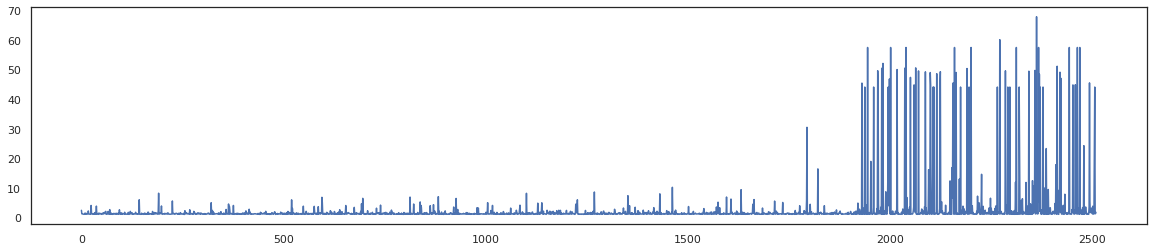

In [188]:
plt.figure(figsize=(20,4))
plt.plot(test_scores)

In [189]:
print(test_scores.shape)
np.savetxt('/content/drive/My Drive/MDI341 - Data Challenge/submissions/V9_feature_bagging.csv', test_scores, fmt = '%1.6f', delimiter=',')

(2511,)


Back to [table of contents](#TOC)